In [5]:
# подключаем все нужные библиотеки
import numpy as np             
import matplotlib.pyplot as plt 
%matplotlib inline 
import pandas as pd             
import seaborn as sns           
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import neighbors
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# HR Aalysis
## Problem statement
Это набор данных HR. Ежегодно в компании продвигается по карьерной лестнице около 5% сотрудников. Итак, нужно построить модель, решающую проблему бинарной классификации и определить сотрудника повысят в должности или нет? В качестве первого задания мы рассмотрим алгоритм К ближайших соседей и зависимость ошибки на тестовых и тренировочных данных от количества соседей. Затем применим предобработку признаков с помощью метода главных компонент и посмотрим работу SVM на этих данных, как с применением PCA, так и без него.

## Download data and data description

Загрузим данные в Pandas. Данные взяты с [Kaggle](https://www.kaggle.com/shivan118/hranalysis?select=train.csv)

In [6]:
train_raw, test_raw = pd.read_csv('train.csv'), pd.read_csv('test.csv')
print('train data: \n', train_raw.head())
print('\n test data: \n', test_raw.head())
print(f'test shape: {test_raw.shape}, train shape: {train_raw.shape}')


train data: 
    employee_id         department     region         education gender  \
0        65438  Sales & Marketing   region_7  Master's & above      f   
1        65141         Operations  region_22        Bachelor's      m   
2         7513  Sales & Marketing  region_19        Bachelor's      m   
3         2542  Sales & Marketing  region_23        Bachelor's      m   
4        48945         Technology  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   35                   5.0   
1               other                1   30                   5.0   
2            sourcing                1   34                   3.0   
3               other                2   39                   1.0   
4               other                1   45                   3.0   

   length_of_service  KPIs_met >80%  awards_won?  avg_training_score  \
0                  8              1            0            

Мы видим, что данные для тренировки содержат 54808 объектов и 14 признаков, причем как номинальных, так и числовых. Тестовые же данные содержат 23490 записей и как уже видно по столбцу `previous_year_rating` содержат пропущенные значения, что не очень хорошо для тестового датасета.

Всего представленны следующие признаки, к сожалению в источнике данных не указано конкретное описание каждого признака, поэтому мы должны определить это исходя из логических рассуждений:
* employee_id - id сотрудника
* department - отдел
* region - регион, где работает сотрудник
* education - образование
* gender - пол
* recruitment_channel - скорее всего источник найма
* nooftrainings - количество тренингов/обучений, которые прошел сотрудник
* age - возраст
* previousyearrating - какой-то показатель рейтинга сотрудника за прошлый год
* lengthofservice - стаж работника
* KPIs_met >80% - бинарный категориальный признак показателя эффективности*. Если он выше 80% - 1, иначе - 0
* awards_won? - наличие наград
* avgtrainingscore - средний балл, полученный на тренингах и различного рода обучений
* is_promoted - сотрудник был повышен или нет, целевой признак для предсказания

\*KPI (Key Performance Indicator) — это показатель достижения успеха в определенной деятельности или в достижении определенных целей. Можно сказать, что KPI — это количественно измеримый индикатор фактически достигнутых результатов.

Прежде всего давайте переименнуем признаки для удобства:


In [7]:
train_raw.columns = ['id', 'department', 'region', 'education', 'gender', 
                 'recr_source', 'training_num', 'age', 'prev_year_rating', 
                 'service', 'kpi_80', 'awards', 'avg_training_score', 'promotion']

test_raw.columns = ['id', 'department', 'region', 'education', 'gender', 
                 'recr_source', 'training_num', 'age', 'prev_year_rating', 
                 'service', 'kpi_80', 'awards', 'avg_training_score']

## Data analysis and visualization
Сначала посмотрим на тип наших признаков:

In [8]:
for i in train_raw.columns:
    print(f'{i} : {train_raw[i].dtype}')

id : int64
department : object
region : object
education : object
gender : object
recr_source : object
training_num : int64
age : int64
prev_year_rating : float64
service : int64
kpi_80 : int64
awards : int64
avg_training_score : int64
promotion : int64


Видно, что наши признаки включают в себя как номинальные, например `department` или `region `, количественные дискретные (`age`, `service`), непрервный количественный (`prev_year_rating `), бинарные категориальные, такие как `kpi_80`, `awards`.

### Check duplicates
Для начала посмотрим, что в нашем датасете нет дубликатов с одинаковыми id, если они есть то оставим только один из них. Затем мы можем удалить колонку id сотрудника, так как она не несет никакой смысловой информации.


In [9]:
print(sum(train_raw.duplicated(subset='id')))
print(sum(test_raw.duplicated(subset='id'))) 

0
0


Не мало важно проверить, нет ли совпадений в тестовом и трейновом датасетах в id людей. Иначе это может привести к не точным и не объективным результатам оценки модели. Воспользуемся объединением множеств с помощью структуры данных set() на основе хеш-таблицы для быстрой работы.

In [10]:
set(train_raw.id.values).intersection(set(test_raw.id.values))

set()

In [11]:
# Отлично, теперь можно избавиться от признака идентификатора личности.
train_raw = train_raw.drop(columns='id')
test_raw = test_raw.drop(columns='id')

## Feature visualization

Посмотрим на распределение значений для каждого признака. Будем делать это только для трейнового датасета в предположении, что оба набора данных получены из одной генеральной совокупности. Также методом `describe` получим числовые характеристики для каждого признака.

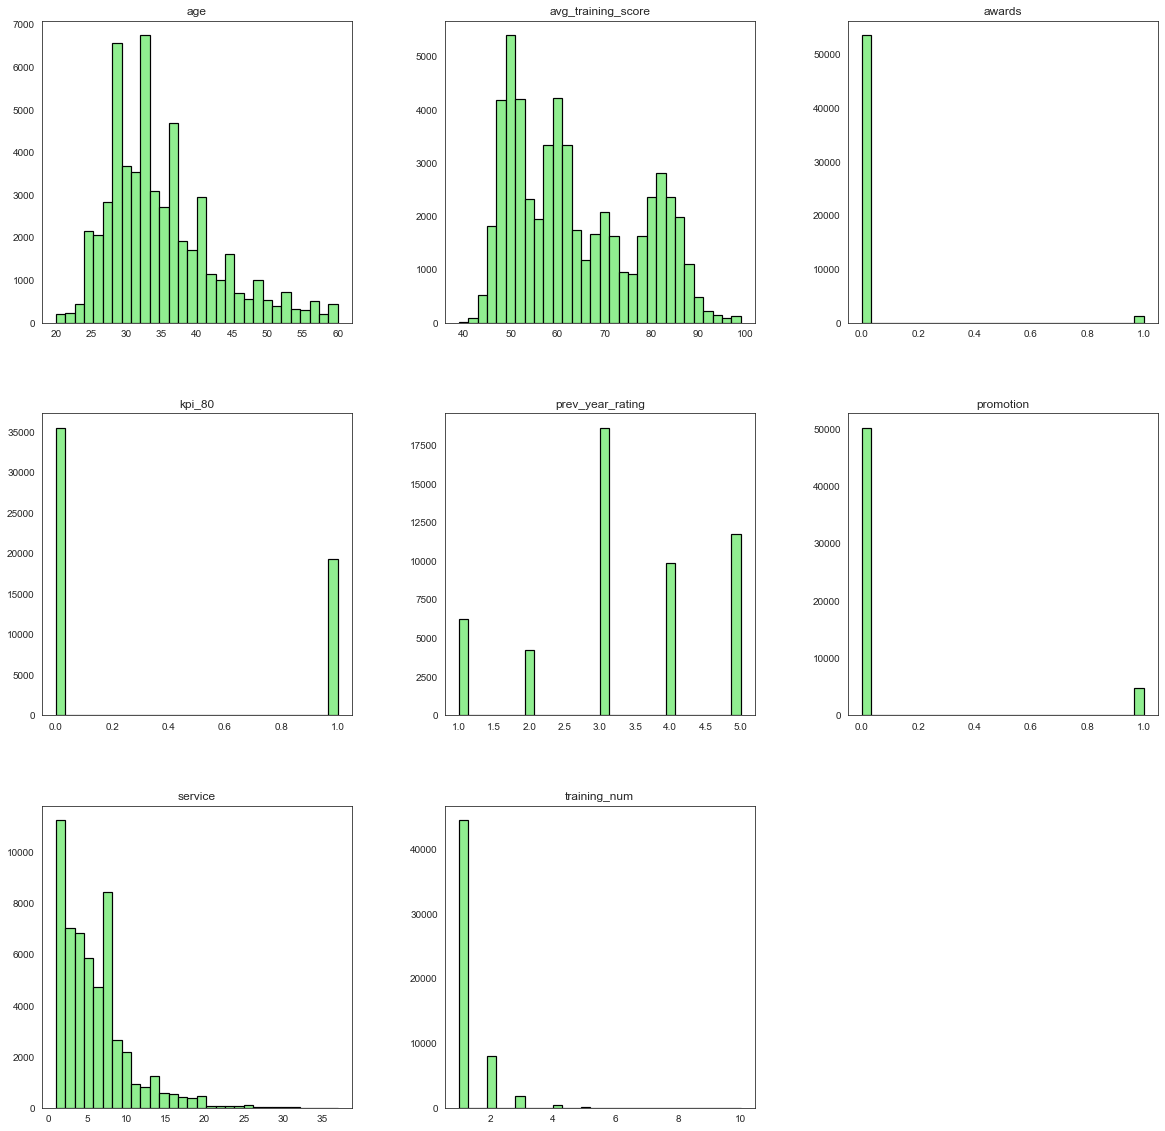

In [12]:
sns.set_style("white")
axes = train_raw.hist(edgecolor='black', color='lightgreen', linewidth=1.2, figsize=(20, 20), 
                      grid=False, backend='matplotlib', bins=30);

In [13]:
train_raw.describe()

,training_num,age,prev_year_rating,service,kpi_80,awards,avg_training_score,promotion
count,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


___
Из данных графиков мы можем сделать следующие выводы:
Возраст людей зрительно распределен более или менее нормально, хоть и с некоторым скосом мат ожидания влево. Распределение средних оценок по тренингам имеет несколько выраженных пиков (~ 50, 60, 70 и 85), мат ожидание же составляет 63.4. Видим, что все номинальные признаки довольно не сбалансированы и одна подкатегория доминирует над другими. Распределение стажа сотрудников имеет сильный скос влево и мат ожидание составляет примерно 5.8 лет. В основном большинство работников получают оценку "3" по рейтингу за предыдущий год. Каких-то выбросов в данных не замечено. Единственное на что можно обратить внимание это количество пройденных обучений. Все сотрудники прошли как минимум 1 тренинг за год, большинство на этом остановилось, но есть некоторые личности, которые смогли пройти 8,9 и даже 10 тренингов. Внизу виден график Violinplot, который получился "дискретным". Можно видеть, что число обучений больше 4х довольно сильно отклоняется от среднего. Но я думаю, что не стоит это считать ошибочными данными, ведь действительно кто-то мог пройти столько обучений за год. Поэтому мы не будем считать это выбросом.
___

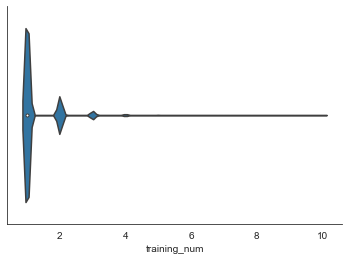

In [14]:
sns.violinplot(train_raw['training_num'])
sns.despine();

Видно, что целевой признак `promotion` сильно несбалансирован по классам. Посмотрим на процентное соотношение

In [15]:
count = train_raw['promotion'].value_counts()
print('не повысили: {}%'.format(round(count[0]*100/(count[0]+count[1]), 2)))
print('повысили: {}%'.format(round(count[1]*100/(count[0]+count[1]), 2)))

не повысили: 91.48%
повысили: 8.52%


___
Далее посмотрим на корреляцию данных. Просто смотреть на числа не очень удобно. Напишем фукцию в основе которой лежит heatmap из библиотеки seaborn.

In [16]:
def correlation_map(df, method='pearson'):
    # create a correlation matrix
    corr = df.corr(method=method)
    
    # create a triangular mask to avoid repeated values and make
    # the plot easier to read
    corr = corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(corr), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(corr, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()

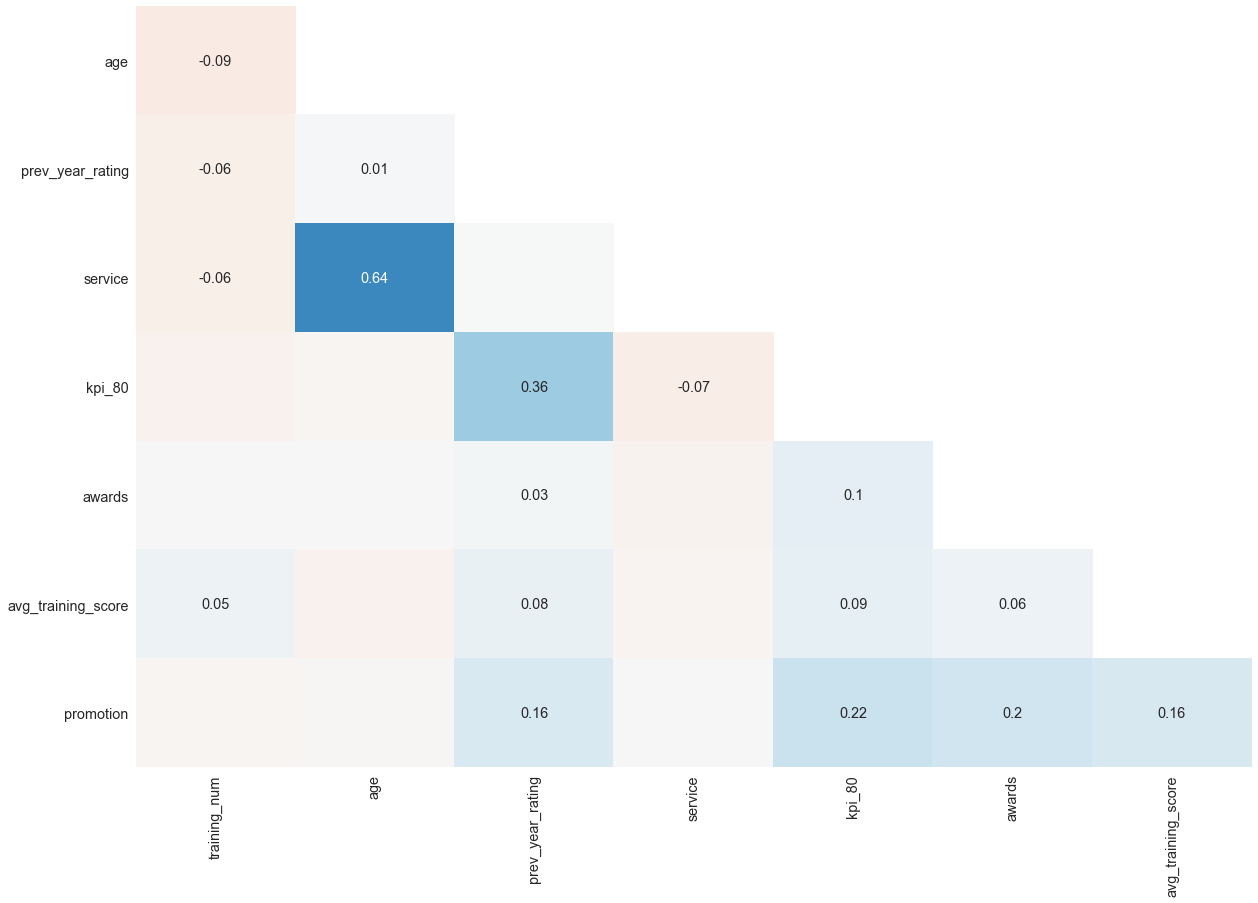

In [17]:
# распределения на построенных графиках выглядят не очень нормальным, поэтому воспользуемся параметрическим методом вычисления
# коэффициента корреляции Спирмена.
correlation_map(train_raw, method='spearman')

Логично, что чем выше выше возраст сотрудника, тем больше его стаж, хоть и не всегда это так. Также имеется небольшая корреляция между рейтингом сотрудника за прошлый год и коэффициентом эффективности, хотя и не очень значительная (под значительной будем понимать коэффициент корреляции больше 0.7).

Также видим, что признаки не сильно коррелируют с целевым значением `promotion` (далее просто таргет). 

Таким образом, у нас отсутствует явная линейная связь между признаками, а также отстутсвует сильная связь между признаками и таргетом. Поэтому мы можем оставить все как есть в этом плане.

___
Интересено посмотреть на некоторые зависимости поближе. Например, мы видим, что возраст и стаж никак не коррелируют с повышением. Посмотрим на графики.

In [18]:
# восспользуемся функцией crosstab. Она создает кросс табуляцию двух или нескольких факторов
data = pd.crosstab(train_raw['service'], train_raw['promotion'])
data.head(5)

promotion,0,1
service,,
1,4170,377
2,6089,595
3,6424,609
4,6238,598
5,5357,475


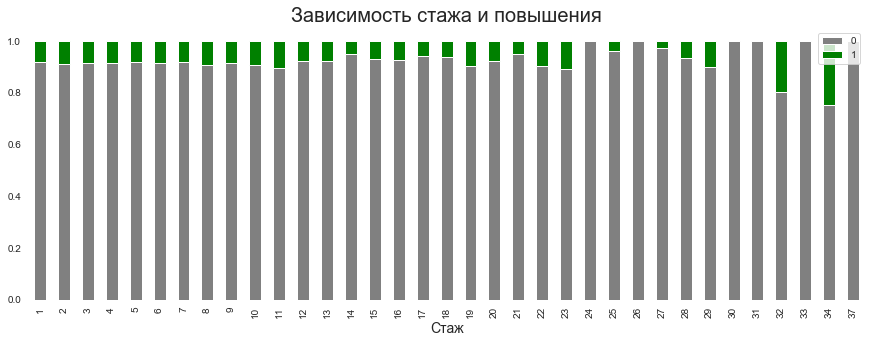

In [19]:
# нормируем данные для удобства
data = data.div(data.sum(1).astype('float'), axis = 0)
data.plot(kind = 'bar', stacked = True, figsize = (15, 5), color = ['grey', 'green'])
plt.box(False)
plt.title('Зависимость стажа и повышения', fontsize = 20)
plt.xlabel('Стаж', fontsize = 14)
plt.legend(loc='upper right');

Из графика наглядно видно, что повышают как не очень опытных, так и более опытных сотрудников. Максимальное же количество повышений можно наблюдать для возраста 32-34 года. 

___
Проделаем тоже самое для возраста

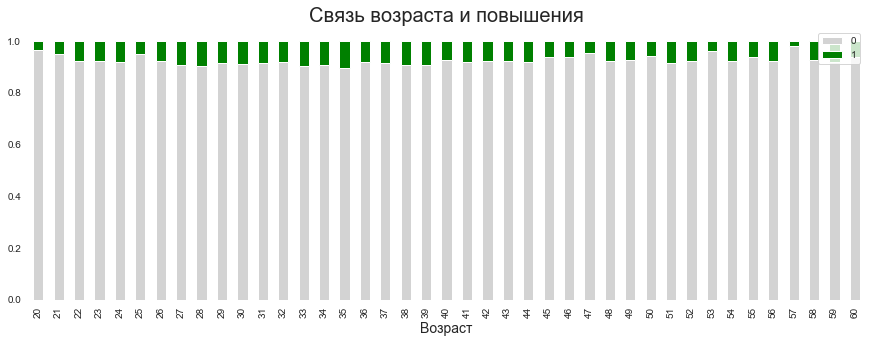

In [20]:
df = pd.crosstab(train_raw['age'], train_raw['promotion'])
df = df.div(df.sum(1).astype('float'), axis = 0)
df.plot(kind = 'bar', stacked = True, figsize = (15, 5), color = ['lightgrey', 'green'])

plt.title('Связь возраста и повышения', fontsize = 20)
plt.xlabel('Возраст', fontsize = 14)
plt.box(False)
plt.legend(loc='upper right');

Это интересное наблюдение, из которого видно, что повышают как молодых сотрудников, так даже и людей в уже пред пенсионном возрасте (55-60 лет). То есть для данной компании не важен возраст сотрудника и это не причина не давать повышение

___
На следующих графиках видно общее соотношение полученных наград, видимо в каких то соревнованиях, и зависимость повышения от того, получил ли награду сотрудник или нет. Видно, что количество тех сотрудников которые получили награду значительно меньше, так же видно, что сотрудников с наградой повышают больше. Но я думаю, это зависимость от третьего фактора, а именно, если сотрудник получил какую-то награду, то скорее всего он лучше работает и активнее себя проявляет. Само по себе наличие награды, думаю, что влияет не сильно, это показывает достаточно не высокий коэффициент корреляции.

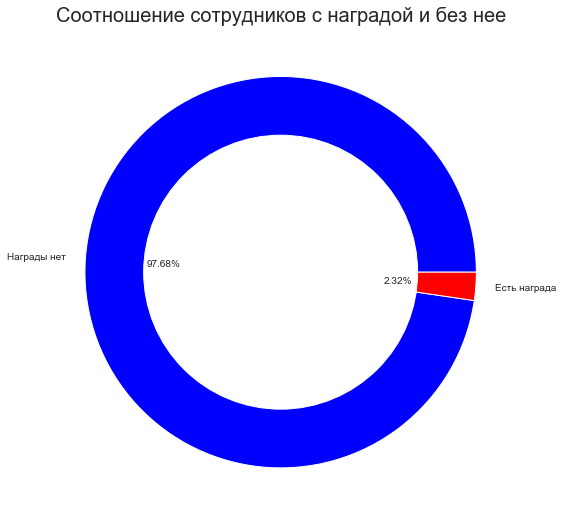

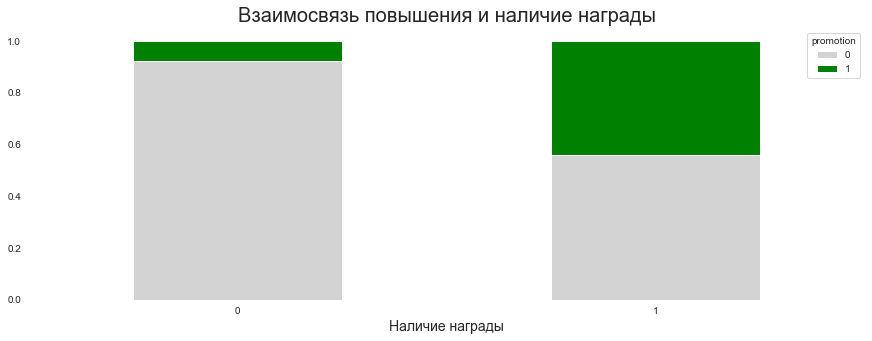

In [21]:
colors = ['blue', 'red']
labels = "Награды нет", "Есть награда"

my_circle = plt.Circle((0, 0), 0.7, color = 'white')
size = [53538, 1270]
plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, labels = labels, autopct = '%.2f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Соотношение сотрудников с наградой и без нее', fontsize = 20)

df = pd.crosstab(train_raw['awards'], train_raw['promotion'])
df = df.div(df.sum(1).astype('float'), axis = 0)
df.plot(kind = 'bar', stacked = True, figsize = (15, 5), color = ['lightgrey', 'green'])
plt.title('Взаимосвязь повышения и наличие награды', fontsize = 20)
plt.xlabel('Наличие награды', fontsize = 14)
plt.xticks(rotation=0)
plt.box(False)

___
Далее заметим, во-первых, что данные типа `float`, но на самом деле здесь всего 5 значений, можно рассматривать это как пять категорий, логично было бы перевести в тип `int`. Также видно, что впринципе чем больше значение рейтинга, тем больше число повышений. Наиболее же частый рейтинг равен трем.

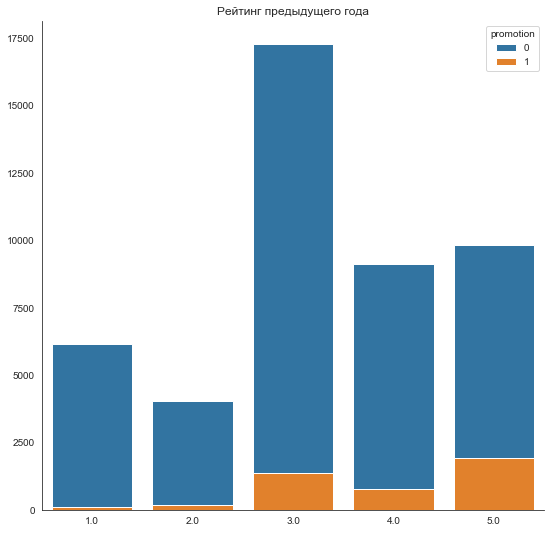

In [22]:
sns.countplot('prev_year_rating', hue='promotion', data=train_raw, dodge=False)
plt.title('Рейтинг предыдущего года')
plt.ylabel('')
plt.xlabel('')
sns.despine()

___
Ну и в конце интересно было бы посмотреть на уровень образования и его влияние на повышение



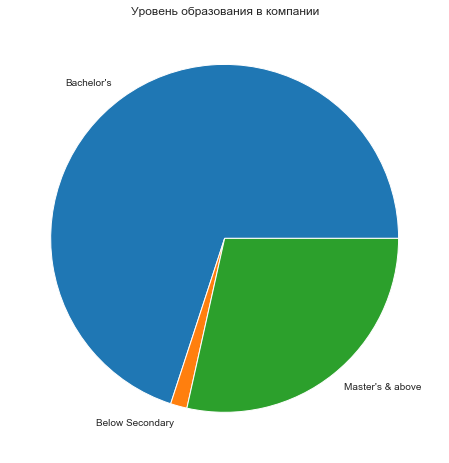

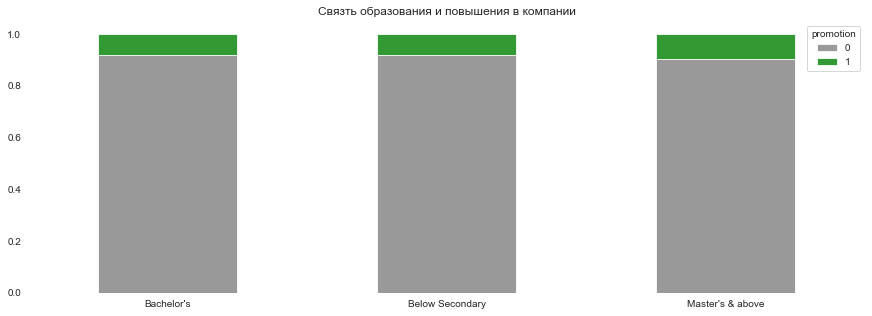

In [23]:
df = train_raw.groupby('education').size()
df.plot(kind='pie', subplots=True, figsize=(15, 8))
plt.ylabel('')
plt.title('Уровень образования в компании');

df = pd.crosstab(train_raw['education'], train_raw['promotion'])
df = df.div(df.sum(1).astype('float'), axis = 0)
df.plot(kind = 'bar', stacked = True, figsize = (15, 5), color = ['grey', 'green'], alpha=0.8)
plt.title('Связть образования и повышения в компании')
plt.xticks(rotation=0)
plt.xlabel('')
plt.box(False);

Большинство сотрудников имеют образование бакалавриата, есть сотрудники без высшего образования. Интересно, что уровень образования абсолютно никак не влияет на повышение. Например, люди без образования получают повышение не реже, чем бакалавры. Впринципе данный признак можно вовсе исключить из модели, так как он не играет никакой роли на таргетное значение повышения.

### Dealing with null variables

Исследуем количество пропущенных значений

In [24]:
# Посмотрим на пропущенные значения в виде таблички в процентах
def missing_data_in_percentage(df):
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())
        print('{} - {}%'.format(col, round(pct_missing*100)))

In [25]:
missing_data_in_percentage(train_raw)

department - 0.0%
region - 0.0%
education - 4.0%
gender - 0.0%
recr_source - 0.0%
training_num - 0.0%
age - 0.0%
prev_year_rating - 8.0%
service - 0.0%
kpi_80 - 0.0%
awards - 0.0%
avg_training_score - 0.0%
promotion - 0.0%


In [26]:
missing_data_in_percentage(test_raw)

department - 0.0%
region - 0.0%
education - 4.0%
gender - 0.0%
recr_source - 0.0%
training_num - 0.0%
age - 0.0%
prev_year_rating - 8.0%
service - 0.0%
kpi_80 - 0.0%
awards - 0.0%
avg_training_score - 0.0%


Визуализируем пропущенные данный с помощью heat plot

In [27]:
def plot_null_matrix(df, figsize=(10,10)):
    # initiate the figure
    plt.figure(figsize=figsize)
    # create a boolean dataframe based on whether values are null
    df_null = df.isnull()
    # create a heatmap of the boolean dataframe
    sns.heatmap(~df_null, cbar=False, yticklabels=False)
    plt.xticks(rotation=90, size='x-large')
    plt.show()

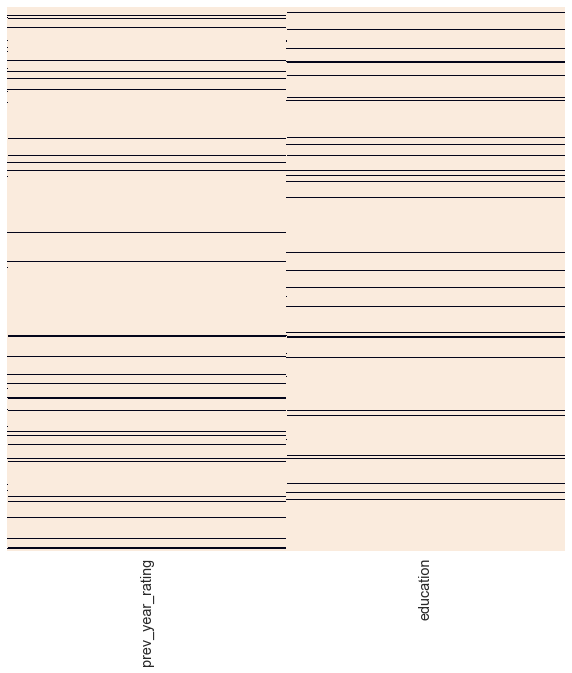

In [28]:
plot_null_matrix(train_raw[['prev_year_rating', 'education']])

In [29]:
# посмотри на корреляцию признаков с пропущенными значениями 
cols_with_missing_vals = train_raw.columns[train_raw.isnull().sum() > 0]
missing_corr_train = train_raw[cols_with_missing_vals].isnull().corr()
print(missing_corr_train)

cols_with_missing_vals = test_raw.columns[test_raw.isnull().sum() > 0]
missing_corr_test = test_raw[cols_with_missing_vals].isnull().corr()
print('\n', missing_corr_test)

                  education  prev_year_rating
education          1.000000          0.068744
prev_year_rating   0.068744          1.000000

                   education  prev_year_rating
education          1.000000          0.074076
prev_year_rating   0.074076          1.000000


___
Видно, что признаки с пропущенными данными не коррелируют между собой.

У нас есть несколько вариантов борьбы с пропущенными данными, удалить эти объекты, либо заполнить эти пропущенные данные. Так как пропущенных значений в `education` мало, и как мы видели присутствует сильное доминирование одного класса над другими, мы могли бы заполнить эти данные модой.

Что касается `prev_year_rating`, то этот признак достаточно сильно влияет на задачу классификации и нужно дополнительно исследовать природу пропущенных значений 

In [30]:
train_raw[train_raw['prev_year_rating'].isnull()].head(20)

,department,region,education,gender,recr_source,training_num,age,prev_year_rating,service,kpi_80,awards,avg_training_score,promotion
10,Technology,region_23,NaN,m,sourcing,1,30,NaN,1,0,0,77,0
23,Procurement,region_5,Bachelor's,m,other,1,27,NaN,1,0,0,70,0
29,Sales & Marketing,region_4,Bachelor's,m,sourcing,1,26,NaN,1,0,0,44,0
56,Sales & Marketing,region_31,Bachelor's,f,other,1,29,NaN,1,0,0,49,0
58,Sales & Marketing,region_16,Bachelor's,m,other,2,27,NaN,1,1,0,47,0
62,Analytics,region_22,Bachelor's,f,other,1,28,NaN,1,1,0,80,0
66,Finance,region_22,Bachelor's,m,other,1,27,NaN,1,1,1,58,1
67,Sales & Marketing,region_22,Bachelor's,m,sourcing,1,27,NaN,1,0,0,61,1
84,Legal,region_7,Bachelor's,m,other,1,29,NaN,1,0,0,65,1
89,Sales & Marketing,region_31,Bachelor's,f,other,1,31,NaN,1,0,0,51,0


Заметим, что пропущенные значения для этого признака соответствуют новым сотрудникам. Посмотрим, выполняется ли это предположение для всех пропущенных значений

In [31]:
train_raw[train_raw['prev_year_rating'].isnull()]['service'].value_counts()

1    4124
Name: service, dtype: int64

Это логично, так как сотрудник отработал всего год и не имеет оценки своей трудовой деятельности за прошлый год.
Я предлагаю заполнить эти значения нулями. Это будет показывать модели, что сотрудник вновь прибывший и у него нет оценки рейтинга.

Но выполняется ли это в обратную сторону

In [32]:
train_raw[train_raw['service']==1]['prev_year_rating'].value_counts(dropna=False)

NaN    4124
3.0     158
4.0     114
5.0      64
1.0      44
2.0      43
Name: prev_year_rating, dtype: int64

___
На самом деле, существуют работники для которых стаж равен одному году, но они уже имеют оценку за прошлый год. Это может быть из-за того, что работника повысили уже после аттестации его за прошлый год, но еще не прошло два года, и допустим повышение произошло после 1.5 года работы. Чтобы не дезинформировать модель, я предлагаю заменить стаж для таких сотрудников на 2 года, к тому же их не так много по сравнению с теми, у которых стаж 1 год и нет оценки за прошлый.

Да, будет 100% корреляция этого признака и сроком работы для новых сотрудников, но я считаю это лучше, чем заполнять этот признак уже имеющимися значениями, это будет вводить в заблуждение модель, или тем более удалять всех новых сотрудников. В данном случае, значение `prev_year_rating` = 0 будет индикатором того, что сотрудник отработал всего год и не имеет оценки за прошлый.

In [33]:
# # для тренировочных данных
train_raw.loc[:,'education'].fillna(train_raw['education'].mode()[0], inplace = True)
train_raw.loc[:,'prev_year_rating'].fillna(0, inplace = True)
# изменяем стаж, как написано выше 
train_raw.loc[(train_raw['prev_year_rating'] != 0) & (train_raw['service'] == 1), 'service'] = 2

# # для тестовых данных
test_raw.loc[:,'education'].fillna(test_raw['education'].mode()[0], inplace = True)
test_raw.loc[:,'prev_year_rating'].fillna(0, inplace = True)
test_raw.loc[(test_raw['prev_year_rating'] != 0) & (test_raw['service'] == 1), 'service'] = 2

# проверяем остались ли пропущенные данные
print(train_raw.isnull().sum().sum())
print(test_raw.isnull().sum().sum())

0
0


In [34]:
# поменяем тип данных с float на int
test_raw['prev_year_rating'] = test_raw['prev_year_rating'].astype(int)
train_raw['prev_year_rating'] = train_raw['prev_year_rating'].astype(int)

### Data normalization

У нас нет непрерывных количественных признаков, но некоторые дискретные количественные признаки можно было бы привести к стандартному распределению, так как это влияет на работу многих алгоритмов. Такие признаки - это возраст, стаж, средняя оценка за обучение (`avg_training_score`) и количество тренингов.

In [35]:
# делаем выборку и нормализуем для тренировочного датасета
train_subset = train_raw[['age', 'avg_training_score', 'service', 'training_num']] 
train_subset_stand = (train_subset - train_subset.mean())/train_subset.std()
train_subset_stand.describe()

,age,avg_training_score,service,training_num
count,5.480800e+04,5.480800e+04,5.480800e+04,5.480800e+04
mean,-3.489359e-16,-6.844296e-17,2.858204e-18,2.137098e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.932583e+00,-1.823778e+00,-1.144708e+00,-4.152724e-01
25%,-7.576746e-01,-9.263504e-01,-6.749139e-01,-4.152724e-01
50%,-2.354929e-01,-2.532801e-01,-2.051194e-01,-4.152724e-01
75%,5.477796e-01,9.432894e-01,2.646752e-01,-4.152724e-01
max,3.289233e+00,2.663358e+00,7.311593e+00,1.435665e+01


In [36]:
# заменим в датасете
train_raw[['age', 'avg_training_score', 'service', 'training_num']] = train_subset_stand

In [37]:
train_raw.head()

,department,region,education,gender,recr_source,training_num,age,prev_year_rating,service,kpi_80,awards,avg_training_score,promotion
0,Sales & Marketing,region_7,Master's & above,f,sourcing,-0.415272,0.025598,5,0.499572,1,0,-1.075922,0
1,Operations,region_22,Bachelor's,m,other,-0.415272,-0.627129,5,-0.440017,0,0,-0.253280,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,-0.415272,-0.104947,3,0.264675,0,0,-1.001136,0
3,Sales & Marketing,region_23,Bachelor's,m,other,1.226052,0.547780,1,0.969367,0,0,-1.001136,0
4,Technology,region_26,Bachelor's,m,other,-0.415272,1.331052,3,-0.909811,0,0,0.718933,0


In [38]:
# Тоже самое для тестового 
test_subset = test_raw[['age', 'avg_training_score', 'service', 'training_num']] 
test_subset_stand = (test_subset - test_subset.mean())/test_subset.std()
test_raw[['age', 'avg_training_score', 'service', 'training_num']] = test_subset_stand

## Training k-nn classifier

### One hot encoding

Приведем номинальные признаки к one-hot виду. При этом из каждого признака мы уберем один "подпризнак". Так как зная все остальные подпризнаки, мы можем найти данный. Допустим рассмотрим признак `education`. Тогда после преобразования у нас будет 3 столбца, где в одном из них всегда будет 1, а в других нули, тогда можно убрать один столбец, и, зная два других, мы сможем найти третий. Тем самым мы избавимся от лишней информации.

In [39]:
X_train = train_raw.iloc[:, :-1]
y_train = train_raw.iloc[:, -1]

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (54808, 12)
Shape of y_train: (54808,)


In [40]:
X_train = pd.get_dummies(X_train)
X_train.columns

Index(['training_num', 'age', 'prev_year_rating', 'service', 'kpi_80',
       'awards', 'avg_training_score', 'department_Analytics',
       'department_Finance', 'department_HR', 'department_Legal',
       'department_Operations', 'department_Procurement', 'department_R&D',
       'department_Sales & Marketing', 'department_Technology',
       'region_region_1', 'region_region_10', 'region_region_11',
       'region_region_12', 'region_region_13', 'region_region_14',
       'region_region_15', 'region_region_16', 'region_region_17',
       'region_region_18', 'region_region_19', 'region_region_2',
       'region_region_20', 'region_region_21', 'region_region_22',
       'region_region_23', 'region_region_24', 'region_region_25',
       'region_region_26', 'region_region_27', 'region_region_28',
       'region_region_29', 'region_region_3', 'region_region_30',
       'region_region_31', 'region_region_32', 'region_region_33',
       'region_region_34', 'region_region_4', 'region_region

In [41]:
X_train = X_train.drop(columns=['department_Analytics', 'region_region_1',
                                'education_Below Secondary', 'gender_f', 'recr_source_other'])

In [42]:
# заменим все region_region_X на удобочитаемый вид
func = np.vectorize(lambda x: x[7:] if x.startswith('region') else x)
X_train.columns = func(X_train.columns.values)
X_train.columns

Index(['training_num', 'age', 'prev_year_rating', 'service', 'kpi_80',
       'awards', 'avg_training_score', 'department_Finance', 'department_HR',
       'department_Legal', 'department_Operations', 'department_Procurement',
       'department_R&D', 'department_Sales & Marketing',
       'department_Technology', 'region_10', 'region_11', 'region_12',
       'region_13', 'region_14', 'region_15', 'region_16', 'region_17',
       'region_18', 'region_19', 'region_2', 'region_20', 'region_21',
       'region_22', 'region_23', 'region_24', 'region_25', 'region_26',
       'region_27', 'region_28', 'region_29', 'region_3', 'region_30',
       'region_31', 'region_32', 'region_33', 'region_34', 'region_4',
       'region_5', 'region_6', 'region_7', 'region_8', 'region_9',
       'education_Bachelor's', 'education_Master's & above', 'gender_m',
       'recr_source_referred', 'recr_source_sourcing'],
      dtype='object')

In [43]:
# тоже самое для тестового датасета
X_test = test_raw
print("Shape of X_test:", X_test.shape)
X_test = pd.get_dummies(X_test)
X_test = X_test.drop(columns=['department_Analytics', 'region_region_1',
                                'education_Below Secondary', 'gender_f', 'recr_source_other'])
# заменим все region_region_X на удобочитаемый вид
func = np.vectorize(lambda x: x[7:] if x.startswith('region') else x)
X_test.columns = func(X_test.columns.values)
X_test.columns

Shape of X_test: (23490, 12)


Index(['training_num', 'age', 'prev_year_rating', 'service', 'kpi_80',
       'awards', 'avg_training_score', 'department_Finance', 'department_HR',
       'department_Legal', 'department_Operations', 'department_Procurement',
       'department_R&D', 'department_Sales & Marketing',
       'department_Technology', 'region_10', 'region_11', 'region_12',
       'region_13', 'region_14', 'region_15', 'region_16', 'region_17',
       'region_18', 'region_19', 'region_2', 'region_20', 'region_21',
       'region_22', 'region_23', 'region_24', 'region_25', 'region_26',
       'region_27', 'region_28', 'region_29', 'region_3', 'region_30',
       'region_31', 'region_32', 'region_33', 'region_34', 'region_4',
       'region_5', 'region_6', 'region_7', 'region_8', 'region_9',
       'education_Bachelor's', 'education_Master's & above', 'gender_m',
       'recr_source_referred', 'recr_source_sourcing'],
      dtype='object')

### Training a model

Так как в тестовых данных отсутствуют значения по целевому признаку, то будем использовать тренировочные данные при оценке точности алгоритма различными метриками. Сначала разделим датасет на тренировочный и валидационный, затем возьмем список из разного количества соседей для алгоритма k-nn и посмотрим как меняется ошибка на тренировочных и валидационных данных в зависимсоти от этого параметра. 

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)

In [ ]:
n_neibhors = [1,3,5,10,15,20,30,50,70,100,130,150,200]
train_erros=[]
val_errors = []
for k in n_neibhors:
    knn = neighbors.KNeighborsClassifier(k, weights='uniform')
    knn.fit(X_train, y_train)
    val_errors.append(1 - knn.score(X_val, y_val))
    train_erros.append(1 - knn.score(X_train, y_train))

dummy_model - это "глупый" классификатор, который всегда предсказывает класс 0, то есть то, что сотрудника не повысят. У нас этот класс сильно преобладает над другим, поэтому ошибка будет достаточно низкая.

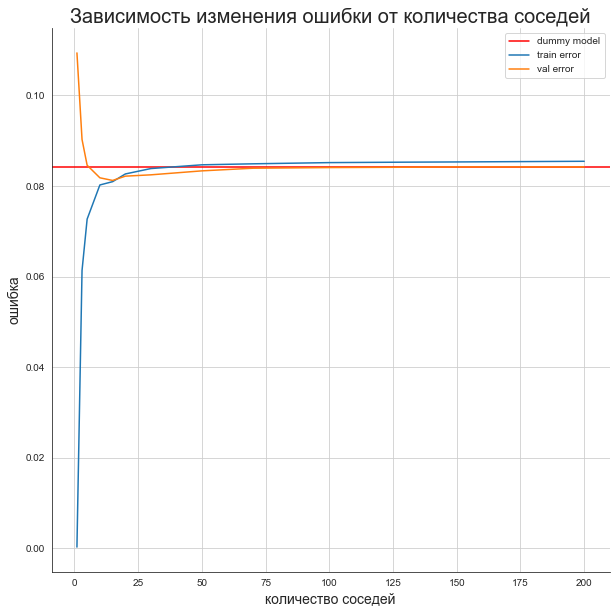

In [113]:
dummy_model = np.mean(y_val != 0)
plt.figure(figsize=(10,10))
plt.axhline(dummy_model, color='red', label='dummy model')
plt.plot(n_neibhors, train_erros, label='train error')
plt.plot(n_neibhors, val_errors, label='val error')
plt.title('Зависимость изменения ошибки от количества соседей', fontsize=20)
plt.xlabel('количество соседей', fontsize=14)
plt.ylabel('ошибка', fontsize=14)
sns.despine()
plt.grid(True)
plt.legend();

Из графика видно, что ошибка на валидационных данных сначала уменьшается с ростом количества соседей, доходит до некоторого минимума, а затем начинает возрастать. Ошибка на тренировочных данных ведет себя иначе. Чем больше количество соседей, тем менее заточен алгорит под обучающий датасет. Минимум валидационной ошибки не сильно выражен, так как данный алгоритм в целом плохо обобщил данные и при любом значении соседей довольно слабо отклоняется от ошибки "глупого" классификатора.

___
Так как в данных очень ярко выраженный дисбаланс классов, то обычная метрика точности не подходит для объективной оценки. Исходя из графика, выберем лучшее значение количества соседей и вычислим метрики подходящие при оценивании модели с дисбалансом классов.

In [115]:
knn = neighbors.KNeighborsClassifier(20, weights='uniform')
knn.fit(X_train, y_train)
predicted = knn.predict(X_val)
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)
# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('Accuracy: {:.2f}'.format(accuracy_score(y_val, predicted)))
print('Precision: {:.2f}'.format(precision_score(y_val, predicted)))
print('Recall: {:.2f}'.format(recall_score(y_val, predicted)))
print('F1: {:.2f}'.format(f1_score(y_val, predicted)))

Accuracy: 0.92
Precision: 0.89
Recall: 0.03
F1: 0.05


Видно, что значение Recall очень низкое. Оно показывает долю истинно положительных значений класса от общего числа значений этого класса. Это значит, что достаточно много объектов класса "повысят" были ложно отнесены алгоритмом к классу "не повысят" 

## PCA and SVM

Рассмотрим метод главных компонент и применим его к нашей задаче, тем самым понизив размерность признаков. Наша цель сохранить как можно больше дисперсии, при этом как можно больше понизить размерность задачи.

Сначала понизим размерность до 2х. Изобразим графики.

In [46]:
pca_model = PCA(n_components = 2)
pca_model.fit(X_train)
print(f"Главные компоненты:\n {pca_model.components_.shape}")
print(f"Дисперсии по главным компонентам:\n {pca_model.explained_variance_}")

Главные компоненты:
 (2, 53)
Дисперсии по главным компонентам:
 [2.50150197 1.5404247 ]


In [105]:
def myplot(score,coeff,labels=None):
    plt.figure(figsize=(10,10))
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    sns.scatterplot(xs * scalex,ys * scaley, hue = y_train)
    for i in range(0, 5):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r', alpha = 0.5, width = 5e-4, head_width = 5e-3)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'black', ha = 'center', va = 'center', fontsize=16)
        else:
            plt.text(coeff[i,0]* 1.15 - 0.1, coeff[i,1] * 1.15 - 0.1, labels[i], color = 'black', ha = 'center', va = 'center', fontsize=16)
    sns.despine()

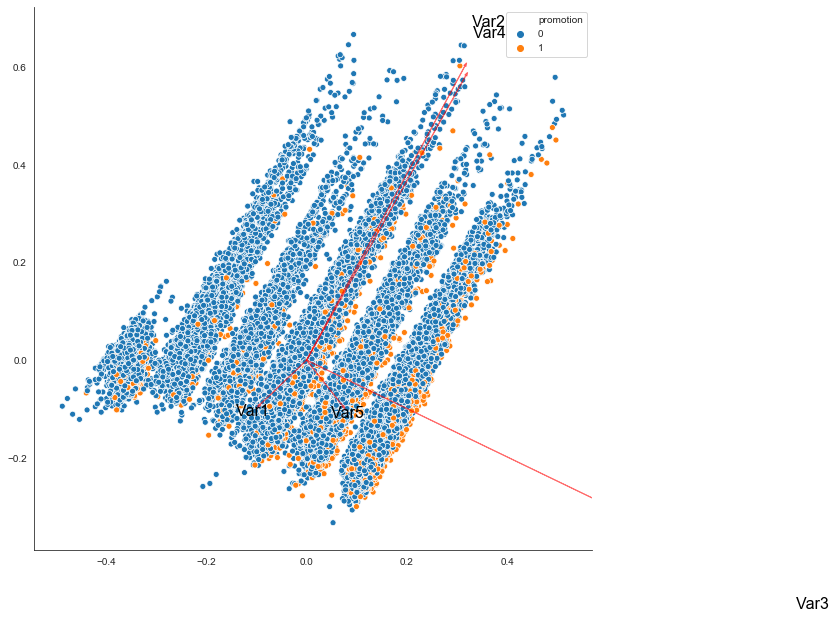

In [106]:
X_new = pca_model.transform(X_train)
myplot(X_new, np.transpose(pca_model.components_))

Посмотрим на долю дисперсии объясненной PCA, в зависимости от количества главных компонент

In [124]:
pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

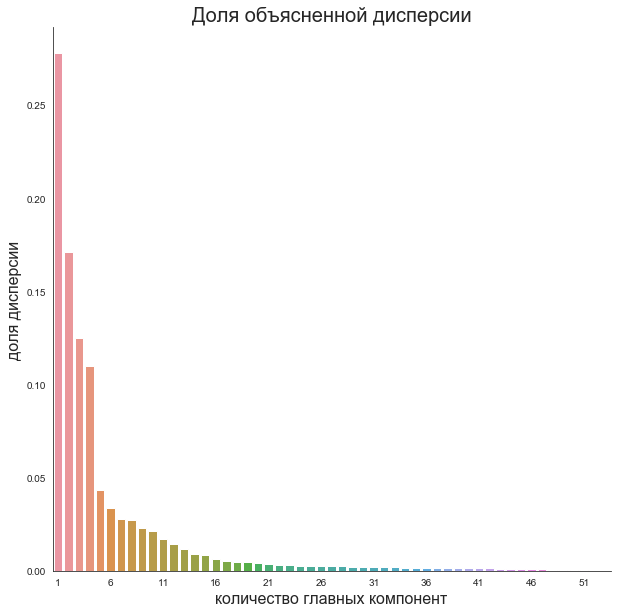

In [125]:
plt.figure(figsize=(10,10))
sns.barplot(np.arange(1, pca.n_features_ + 1), pca.explained_variance_ratio_)
ticks=list(range(0,pca.n_features_+1,5))
labels = list(range(1,pca.n_features_+1,5))
plt.xticks(ticks=ticks, labels=labels)
plt.title('Доля объясненной дисперсии', fontsize=20)
plt.xlabel('количество главных компонент', fontsize=16)
plt.ylabel('доля дисперсии', fontsize=16)
sns.despine()

Из этого графика видно, что почти всю дисперсию объясняют первые 20 компонент. Тем самым можно предположить, что 20 мерного пространства должно хватить, для решения данной задачи. Но как можно будет увидеть ниже, это не так.
___

Сначала посчитаем F-значение без применения PCA.

In [143]:
svc_linear = SVC(kernel = 'linear')
svc_rb = SVC(kernel = 'rbf')
print('linear and non-linear kernel: ')
for model in svc_linear, svc_rb:
    model.fit(X_train, y_train)
    y_val_pred  = model.predict(X_val)
    print(f1_score(y_val, y_val_pred), end='\t')

linear and non-linear kernel: 
0.22461538461538458	0.2696629213483146	

С помощью жадного поиска (на всех доступных ядрах процессора) и SVC выберем наилучшее количество компонент. Будем использовать 5-fold cross validation 

In [149]:
pipeline = Pipeline(steps = [('pca', PCA()), ('svc', SVC(kernel = 'linear'))])

n_components = [1, 2, *list(range(5,51,5)), 53]
grid_search = GridSearchCV(pipeline, dict(pca__n_components = n_components), scoring='f1', cv=5, verbose=True, n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Grid best parameter (max. {0}): {1}'
          .format('f1', grid_search.best_params_))
print('Grid best score ({0}): {1}'
          .format('f1', grid_search.best_score_))

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed: 10.7min finished


Grid best parameter (max. f1): {'pca__n_components': 53}
Grid best score (f1): 0.21932453710597533


In [150]:
grid_search.cv_results_

{'mean_fit_time': array([ 10.13882403,   9.16339178,  11.81759605,  15.23898211,
         22.51158009,  59.77645068,  78.7547503 , 118.24999628,
        122.12925391, 130.67454939, 134.47201638, 140.09893274,
        100.39674821]),
 'std_fit_time': array([ 0.71998981,  0.1787743 ,  0.28489744,  0.42421979,  0.97448106,
         5.81601648,  9.5118602 ,  4.07908108,  6.37953546,  5.65461046,
         3.87737688,  6.86469689, 11.15225108]),
 'mean_score_time': array([0.44659119, 0.48641543, 0.74939594, 1.07960916, 1.91780162,
        2.80000606, 4.09160118, 4.23459373, 4.76479249, 5.58410606,
        5.91960878, 5.72131839, 3.12019958]),
 'std_score_time': array([0.05531246, 0.03471177, 0.06307993, 0.10195453, 0.10278875,
        0.25009717, 0.2950679 , 0.27121653, 0.22761219, 0.26662115,
        0.45970189, 1.48469469, 1.3870314 ]),
 'param_pca__n_components': masked_array(data=[1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 53],
              mask=[False, False, False, False, False, Fal

Мы видим, что лучшее f значение получается с использованием всего пространства признаков (53), что говорит о том, что метод главных компонент, к сожалению, не помогает для решения данной задачи. Также видно, что классы линейно не разделимы примерно до 30мерного пространства. Это подталкивает на мысль, попробовать нелинейное ядро SVC алгоритма. Проделаем примерно тоже самое, но будем использовать цикл с накоплением ошибки на валидационных данных, чтобы затем визуализировать результат.

In [48]:
print('n_comp','train_err','test_err',sep='\t')
train_err_cum = []
val_err_cum = []
for n_comp in [1, 2, *list(range(5,50,5)), 53]:
    pca_select = PCA(n_components = n_comp)
    pca_select.fit(X_train, y_train)
    X_train_pca = pca_select.transform(X_train)
    X_val_pca  = pca_select.transform(X_val)
    svc = SVC(kernel = 'rbf')
    svc.fit(X_train_pca, y_train)   
    y_train_pred = svc.predict(X_train_pca)
    y_val_pred  = svc.predict(X_val_pca)
    train_err = round(100*np.mean(y_train != y_train_pred),3)
    train_err_cum.append(train_err)
    val_err = round(100*np.mean(y_val != y_val_pred),3)
    val_err_cum.append(val_err)
    print(f'{n_comp}\t{train_err}%\t\t{val_err}%')

n_comp	train_err	test_err
1	8.549%		8.422%
2	8.549%		8.422%
5	8.403%		8.269%
10	8.203%		8.101%
15	7.639%		7.619%
20	7.298%		7.357%
25	7.301%		7.357%
30	7.089%		7.021%
35	7.099%		7.028%
40	7.094%		7.028%
45	7.084%		7.043%
53	6.761%		6.627%


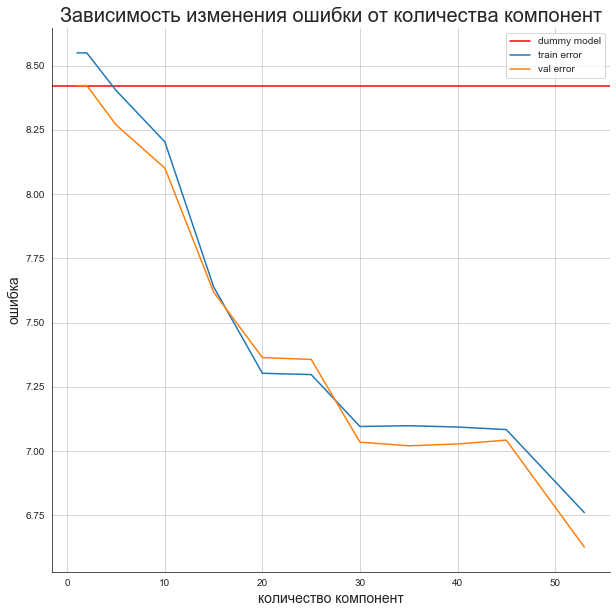

In [156]:
dummy_model = np.mean(y_val != 0)*100
n_comps = [1, 2, *list(range(5,50,5)), 53]
plt.figure(figsize=(10,10))
plt.axhline(dummy_model, color='red', label='dummy model')
plt.plot(n_comps, train_err_cum, label='train error')
plt.plot(n_comps, val_err_cum, label='val error')
plt.title('Зависимость изменения ошибки от количества компонент', fontsize=20)
plt.xlabel('количество компонент', fontsize=14)
plt.ylabel('ошибка', fontsize=14)
sns.despine()
plt.grid(True)
plt.legend();

Видно, что использование всего 53 мерного пространства показывает наилучший результат.
___

Проделаем похожий эксперимент с понижением размерности для knn классификатора. Помним, что наилучшее значение соседей было равно 20.

In [45]:
print('n_comp','train_err','test_err',sep='\t')
train_err_cum = []
val_err_cum = []
knn = neighbors.KNeighborsClassifier(20, weights='uniform')
for n_comp in [1, 2, *list(range(5,50,5)), 53]:
    pca_select = PCA(n_components = n_comp)
    pca_select.fit(X_train, y_train)
    X_train_pca = pca_select.transform(X_train)
    X_val_pca  = pca_select.transform(X_val)
    knn.fit(X_train_pca, y_train)   
    y_train_pred = knn.predict(X_train_pca)
    y_val_pred  = knn.predict(X_val_pca)
    train_err = round(100*np.mean(y_train != y_train_pred),3)
    train_err_cum.append(train_err)
    val_err = round(100*np.mean(y_val != y_val_pred),3)
    val_err_cum.append(val_err)
    print(f'{n_comp}\t{train_err}%\t\t{val_err}%')

n_comp	train_err	test_err
1	8.549%		8.422%
2	8.391%		8.335%
5	8.091%		8.05%
10	8.322%		8.218%
15	8.298%		8.203%
20	8.303%		8.225%
25	8.337%		8.269%
30	8.325%		8.21%
35	8.3%		8.21%
40	8.335%		8.21%
45	8.337%		8.247%
53	8.266%		8.218%


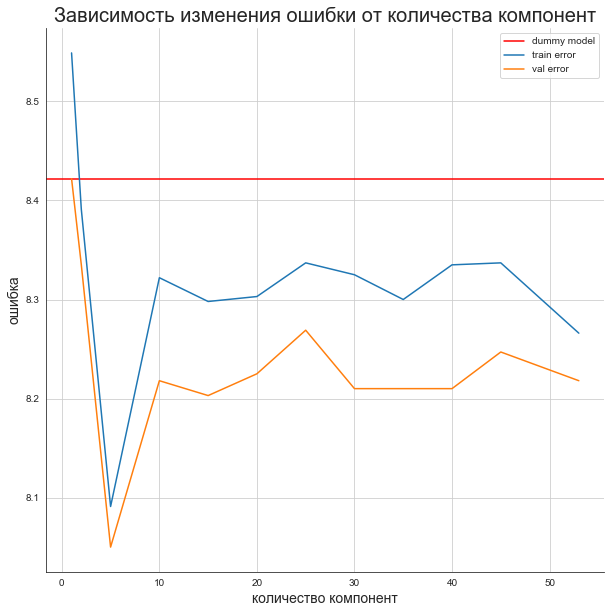

In [46]:
dummy_model = np.mean(y_val != 0)*100
n_comps = [1, 2, *list(range(5,50,5)), 53]
plt.figure(figsize=(10,10))
plt.axhline(dummy_model, color='red', label='dummy model')
plt.plot(n_comps, train_err_cum, label='train error')
plt.plot(n_comps, val_err_cum, label='val error')
plt.title('Зависимость изменения ошибки от количества компонент', fontsize=20)
plt.xlabel('количество компонент', fontsize=14)
plt.ylabel('ошибка', fontsize=14)
sns.despine()
plt.grid(True)
plt.legend();

Здесь же мы получили другой результат. С помощью 5 компонент удалось не только понизить ошибку, но и существенно уменьшить время обучения.

## Conclusion

Таким образом мы исследовали датасет `HR Analysis`, исследовали зависимости между признаками, влияние признаков на таргет задачи, сопроводили все это визуализацией, поборолись с пропущенными значениями и преобразовали данные для тренировки. Затем был исследован алгоритм k близжайших соседей. Данный алгоритм довольно слабо позволяет делать предсказания целового значения при таком дисбалансе классов. Смотря только лишь на значение точности мы не можем объективно сказать о том, как в действительности работает алгоритм и нужны более объекстивные метрики, такие как precision, recall, F-score.

Во второй части мы рассмотрели метод PCA + SVM и подбор количества главных компонент, как с помощью жадного поиска на кросс валидации, так и ручным подсчетом метрик на валидационных данных. Для данной задачи метод понижения размерности не улучшил результаты, скорее всего из-за сильной неравномерности распределения классов и как следствие не тривиальной семантики их разделения. Признаки оказались линейно не разделимы до 30 мерного пространства, SVM с нелинейным ядром лучше справился с задачей и удалось достичь, без кропотливого подбора параметров, с помощью этого метода F score = 0.27, тогда как алгоритм К близжайших соседей дает значение всего 0.05. Тем не менее, применив метод понижения размерности для метода knn, позволило улучшить результаты и  перейти из 53 мерного пространства всего лишь к 5ти мерному.